#Import and Basic Settings

In [91]:
import os as os
os.getcwd()


'/Users/mario/Documents/Github/Education.ai/notebooks'

*Analyse the metrics described in the paper*
- Total funding,
- Description
- Age [extract date - funding date]
- Acqisition (made, aquired); Who aquired it?

In [92]:
#import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
'''
#mount drive
from google.colab import drive
drive.mount('1LbVccBPxo8pR9C41wosD5qYOglKsDrPr')
'''

"\n#mount drive\nfrom google.colab import drive\ndrive.mount('1LbVccBPxo8pR9C41wosD5qYOglKsDrPr')\n"

In [94]:
#import processed dataset
df = pd.read_csv("//Users/mario/Documents/Github/Education.ai/data/2022-12-31_EdTech dataset_processed.csv", index_col=0)

/var/folders/sv/wh2gxdqd7l7g9jyshkbzflxr0000gn/T/ipykernel_12794/2151554003.py:2: DtypeWarning: Columns (78,104,107) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("//Users/mario/Documents/Github/Education.ai/data/2022-12-31_EdTech dataset_processed.csv", index_col=0)


In [95]:
#basic setting for plot layout
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 22})
my_colors = 'muted' #alt: "ch:r=-.2,d=.3_r"

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14046 entries, 0 to 14045
Columns: 125 entries, Organization Name to Class
dtypes: bool(1), float64(36), int64(4), object(84)
memory usage: 13.4+ MB


In [97]:
for i in df.columns: print(i)

Organization Name
Organization Name URL
Founded Date
Founded Date Precision
Industries
Headquarters Location
Description
CB Rank (Company)
Estimated Revenue Range
Operating Status
Exit Date
Exit Date Precision
Closed Date
Closed Date Precision
Company Type
Website
Twitter
LinkedIn
Full Description
Facebook
Headquarters Regions
Investment Stage
Investor Type
Number of Portfolio Organizations
Number of Investments
Number of Lead Investments
Number of Diversity Investments
Number of Exits
Number of Exits (IPO)
Accelerator Program Type
Accelerator Application Deadline
Accelerator Duration (in weeks)
School Type
School Program
Number of Enrollments
School Method
Number of Founders (Alumni)
Industry Groups
Number of Founders
Founders
Number of Employees
Number of Funding Rounds
Funding Status
Last Funding Date
Last Funding Amount
Last Funding Amount Currency
Last Funding Amount Currency (in USD)
Last Funding Type
Last Equity Funding Amount
Last Equity Funding Amount Currency
Last Equity Fund

#Formating Data for Analysis

In [98]:
#defining age calculation
from datetime import date

cut_off = date(2022, 12, 31)

def calculateAge(x):
    t0 = cut_off
    age = t0.year - x.year -((t0.month, t0.day) <
         (x.month, x.day))

    return age

In [99]:
#define a age calculation with a continous value
def calculateAgeDays(x):
  t0 = cut_off
  age = sum([(t0.year- x.year) * 365.25, (t0.month - x.month) * 30, (t0.day - x.day)])

  return age

In [100]:
#converting str in 'Founded Date' to datetime format
from pandas.core.reshape.tile import to_datetime
df['Founded Date'] = to_datetime(df['Founded Date'])

/var/folders/sv/wh2gxdqd7l7g9jyshkbzflxr0000gn/T/ipykernel_12794/1797541815.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Founded Date'] = to_datetime(df['Founded Date'])


In [101]:
#generating 'Age' col from 'Founded Date' col
df['Age'] = df.apply(lambda row : calculateAge(row['Founded Date']), axis = 1)

In [102]:
df['Age in Days'] = df.apply(lambda row : calculateAgeDays(row['Founded Date']), axis = 1)

In [103]:
#split the location cell into actionable parts
df[['City','Country']]  = df['Headquarters Location'].str.rsplit(r",", n=1, expand=True)

In [104]:
#define a function to turn numbers wrongfully identified as dates back into the classification buckets
def emp_corr(var):
  i = str(var)
  if i == '01.Oct':
    return '1-10'
  elif i =='Nov.50':
    return '11-50'
  else:
    return var

In [105]:
#apply the above function to the 'Number of Employees' column
df['Number of Employees'] = df.apply(lambda row : emp_corr(row['Number of Employees']), axis = 1)

#Origin Country of Ventures
Check if findings of Dalle et al. (2017) hold true for the dataset
- mostly US-based *(how is it worded exactlly? majority or just biggest part?)*



In [106]:
#count the values for Countries
countries = df['Country'].value_counts()

In [107]:
#print top 10 countries of origin (overview as appendix)
countries[:10]

Country
 United States      6405
 India              1951
 United Kingdom     1231
 France              357
 Germany             342
 Spain               327
 China               314
 Israel              218
 Switzerland         192
 The Netherlands     190
Name: count, dtype: int64

In [108]:
#reshape 'countries Series' for better visibility in the plot
#the top 10
countries_plt= countries[:10].copy()

#append 'others' category
others = pd.Series({' Others' : countries[10:].sum()})
countries_plt = pd.concat([countries_plt,(others)])

#add column names
countries_plt = pd.DataFrame(countries_plt, copy = True, columns = ['# Ventures'])
countries_plt = countries_plt.reset_index(names='Country')

In [109]:
#insert a column with the ISO 3166 Alpha-3 code for country names to increase readability
countries_plt['Origin'] = ['USA', 'IND', 'GBR', 'FRA','DEU', 'ESP', 'CHN','ISR', 'CHE', 'NLD','others']

In [110]:
#calculate the sample size
countries_plt['# Ventures'].sum()

14004

/var/folders/sv/wh2gxdqd7l7g9jyshkbzflxr0000gn/T/ipykernel_12794/1470902161.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Origin' , y = '# Ventures', data = countries_plt, palette= my_colors,)


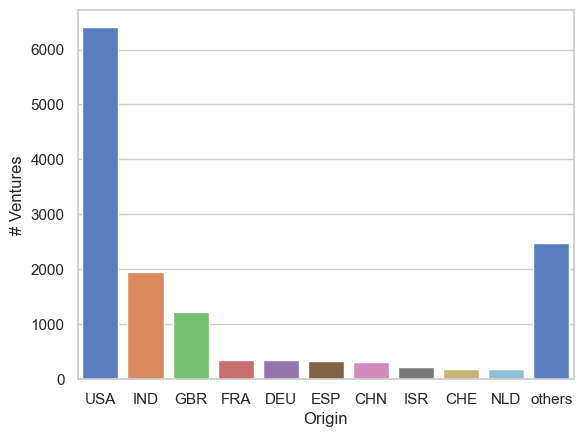

In [111]:
# bar plot
sns.barplot(x = 'Origin' , y = '# Ventures', data = countries_plt, palette= my_colors,)
plt.show()

Note: the assumption found in theory seems to hold true

#Size of Ventures
- mostly small (<50 FTE) firms in sample.

In [112]:
#count the values for small firms
size = df['Number of Employees'].value_counts()

In [113]:
size

Number of Employees
1-10          6987
11-50         4619
51-100         720
101-250        483
251-500        217
501-1000       103
1001-5000       71
10001+          32
5001-10000      16
Name: count, dtype: int64

In [114]:
#calculate the sample size
size.sum()

13248

In [115]:
#calculate percentage of ventures with less than 50 employees
(size['1-10']+ size['11-50'])/size.sum()

0.8760567632850241

#Survival Rate of Ventures

In [116]:
pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [117]:
#Import .xlsx with Data from Statista
df_sr = pd.read_excel("/Users/mario/Documents/Github/Education.ai/data/survival-rates.xlsx",
                    sheet_name = 0)

In [118]:
df_sr['Sample Count'] = df['Age'].value_counts()

In [119]:
survivors = df[df['Operating Status']== 'Active']
df_sr['Sample Survivors'] = survivors['Age'].value_counts()

In [120]:
#calculate the survival rate
df_sr['Sample'] = (df_sr['Sample Survivors'] / df_sr['Sample Count']) * 100

Text(0.5, 0, 'Age')

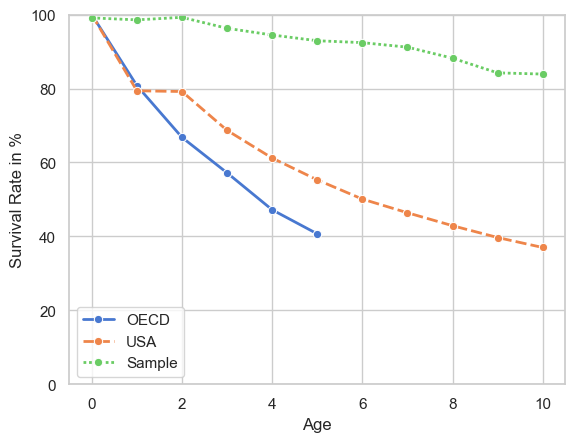

In [121]:
sr_plt = sns.lineplot(data = df_sr[['OECD','USA','Sample']],
                      palette = my_colors,
                      linewidth = 2,
                      marker='o',
                      linestyle= '--')
sr_plt.set_ylim(0, 100)
sr_plt.set_ylabel('Survival Rate in %')
sr_plt.set_xlabel('Age')

Note: OECD values are older; the US rates show the 'Corona-Freeze' in bankrupcy observed also in other economies

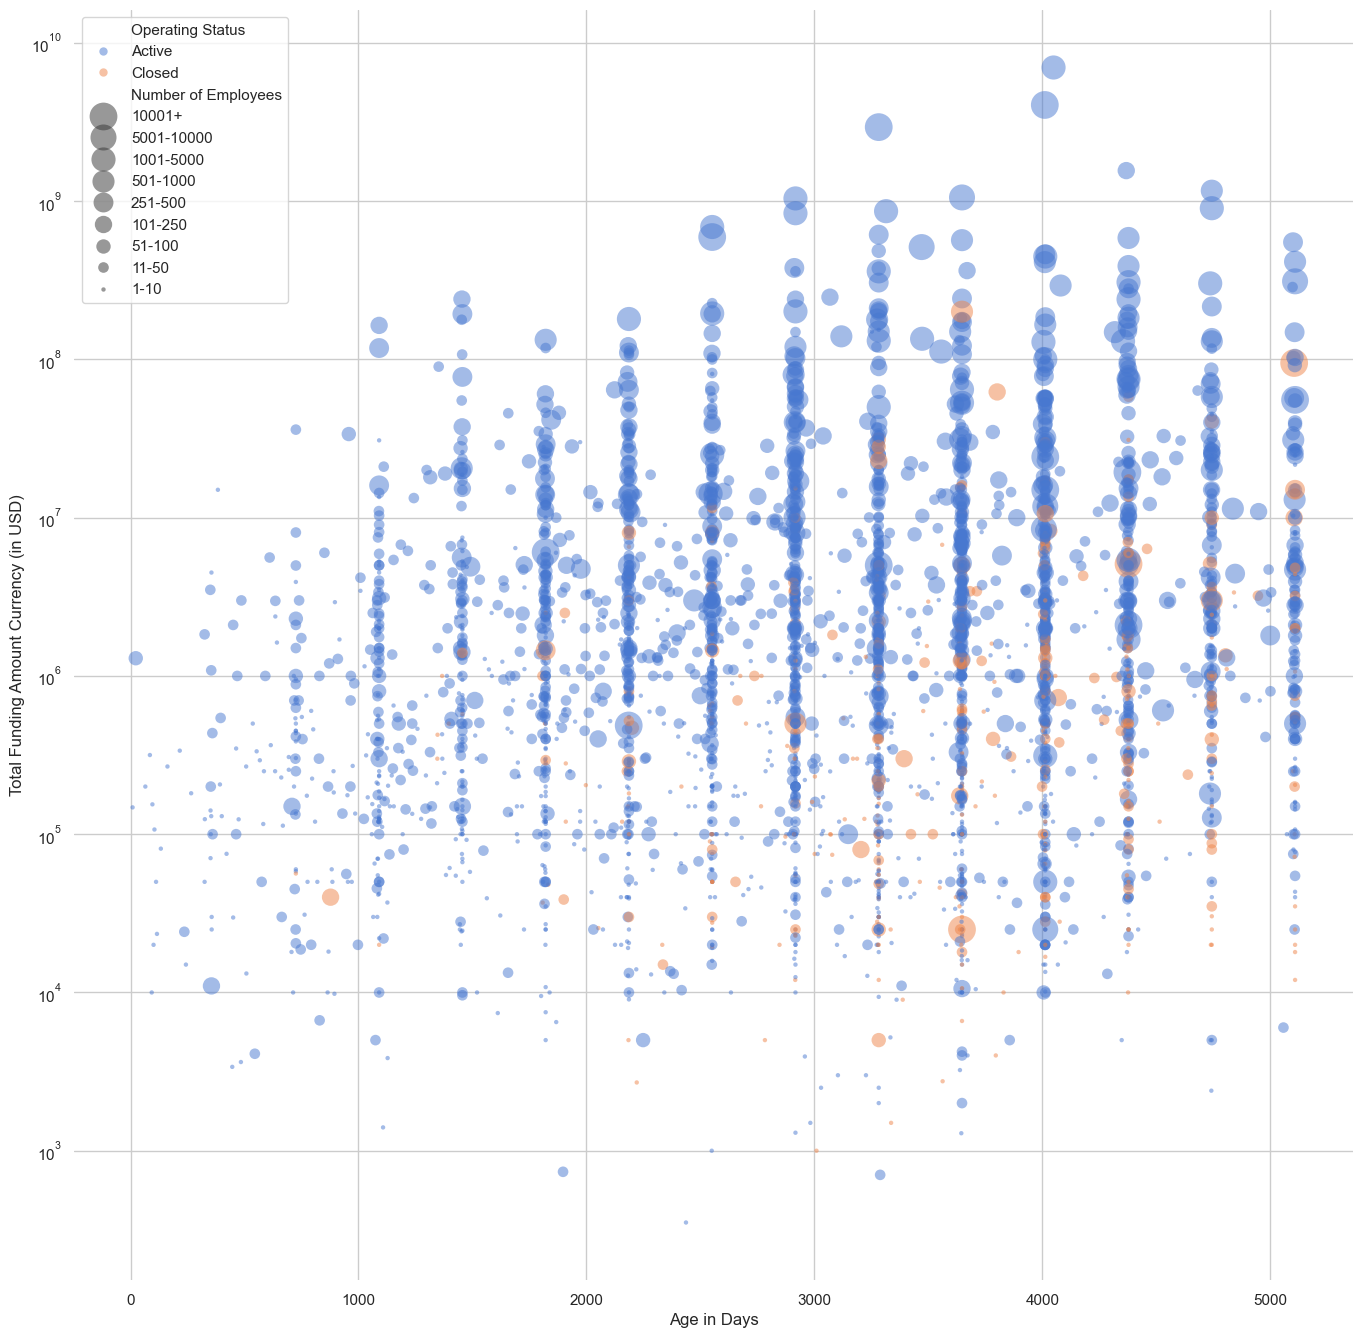

In [122]:
# Draw a scatter plot while assigning point colors and sizes to different variables in the dataset
f, ax = plt.subplots(figsize=(16.5, 16.5))
sns.despine(f, left=True, bottom=True)
#ai_binary = {0: 'non-AI', 1: 'AI'}
size_ranking = ['10001+','5001-10000','1001-5000' ,'501-1000','251-500','101-250','51-100','11-50','1-10']
sns.scatterplot(y="Total Funding Amount Currency (in USD)", x= 'Age in Days',#alt:"Age"
                hue="Operating Status", size="Number of Employees",
                palette= my_colors,
                #hue_order= ai_binary,
                size_order = size_ranking,
                sizes=(10, 400), linewidth=0,
                alpha=.5,
                data=df, ax=ax)
plt.yscale('log')

#Industry Tags (Self-Identification)

In [123]:
#analyse overlap own classification vs. AI; ML Tag in Industry/Verticals column

#Topic Model (Unsupervised Learning)

In [124]:
#enumerate the topics identified by BERTopic
df['Topic'].value_counts()

Topic
-1     8352
 0      698
 1      589
 2      435
 3      375
 4      370
 5      332
 6      258
 7      244
 8      213
 9      210
 10     202
 11     195
 12     181
 13     171
 14     168
 15     166
 16     147
 17     143
 18     137
 19     130
 20     120
 21     107
 22     103
Name: count, dtype: int64

8352 entries could not be fitted into a categorie of more than 100 entries. Topic '-1' is thus dropped from the analysis. See BERTopic documentation.

In [125]:
topic_df = df[df['Topic']!= -1]

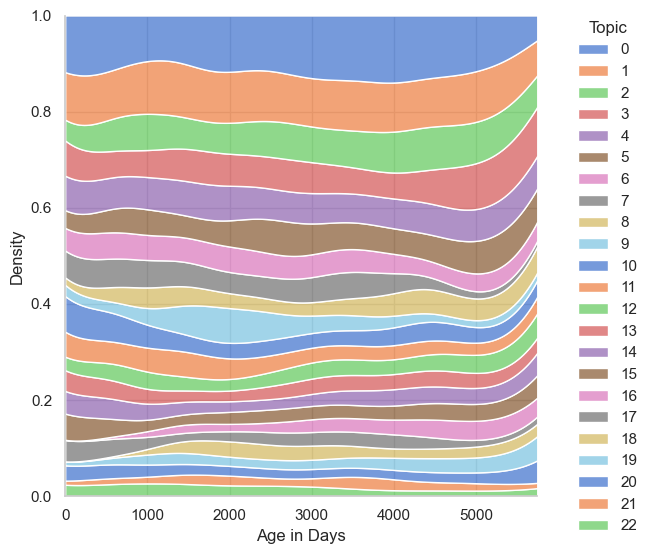

In [126]:
# Plot the distribution of clarity ratings, conditional on carat
#f, ax = plt.subplots(figsize=(16.5, 16.5))
sns.despine(f, left=True, bottom=True)

sns.displot(
    data=topic_df,
    x='Age in Days',#alt:"Age"
    hue="Topic",
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette= my_colors,
)

Topics worth investigating:
Expansion in 10, 15, 17
Decreased interest in 8, 9
Coplete drop of in 16, 18

In [127]:
'''
# Draw a scatter plot while assigning point colors and sizes to different variables in the dataset
f, ax = plt.subplots(figsize=(16.5, 16.5))
sns.despine(f, left=True, bottom=True)
#ai_binary = {0: 'non-AI', 1: 'AI'}
size_ranking = ['10001+','5001-10000','1001-5000' ,'501-1000','251-500','101-250','51-100','11-50','1-10']
sns.scatterplot(y="Total Funding Amount Currency (in USD)",
                x= 'Age in Days',#alt:"Age"
                hue="Topic",
                size="Number of Employees",
                palette= my_colors,
                #hue_order= ai_binary,
                size_order = size_ranking,
                sizes=(10, 400),
                linewidth=0,
                alpha=.5,
                data=df, ax=ax)
plt.yscale('log')
'''

'\n# Draw a scatter plot while assigning point colors and sizes to different variables in the dataset\nf, ax = plt.subplots(figsize=(16.5, 16.5))\nsns.despine(f, left=True, bottom=True)\n#ai_binary = {0: \'non-AI\', 1: \'AI\'}\nsize_ranking = [\'10001+\',\'5001-10000\',\'1001-5000\' ,\'501-1000\',\'251-500\',\'101-250\',\'51-100\',\'11-50\',\'1-10\']\nsns.scatterplot(y="Total Funding Amount Currency (in USD)",\n                x= \'Age in Days\',#alt:"Age"\n                hue="Topic",\n                size="Number of Employees",\n                palette= my_colors,\n                #hue_order= ai_binary,\n                size_order = size_ranking,\n                sizes=(10, 400),\n                linewidth=0,\n                alpha=.5,\n                data=df, ax=ax)\nplt.yscale(\'log\')\n'

In [128]:
Rep_Doc = df[df['Representative_document']== True]

In [129]:
Rep_Doc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 318 to 13955
Columns: 129 entries, Organization Name to Country
dtypes: bool(1), datetime64[ns](1), float64(37), int64(5), object(85)
memory usage: 72.6+ KB


In [130]:
Rep_Doc['Topic']

318      16
412       1
497      15
639      16
826      12
         ..
13520     7
13656     3
13777     7
13943    17
13955    17
Name: Topic, Length: 72, dtype: int64

#Classification (Supervied Learning)

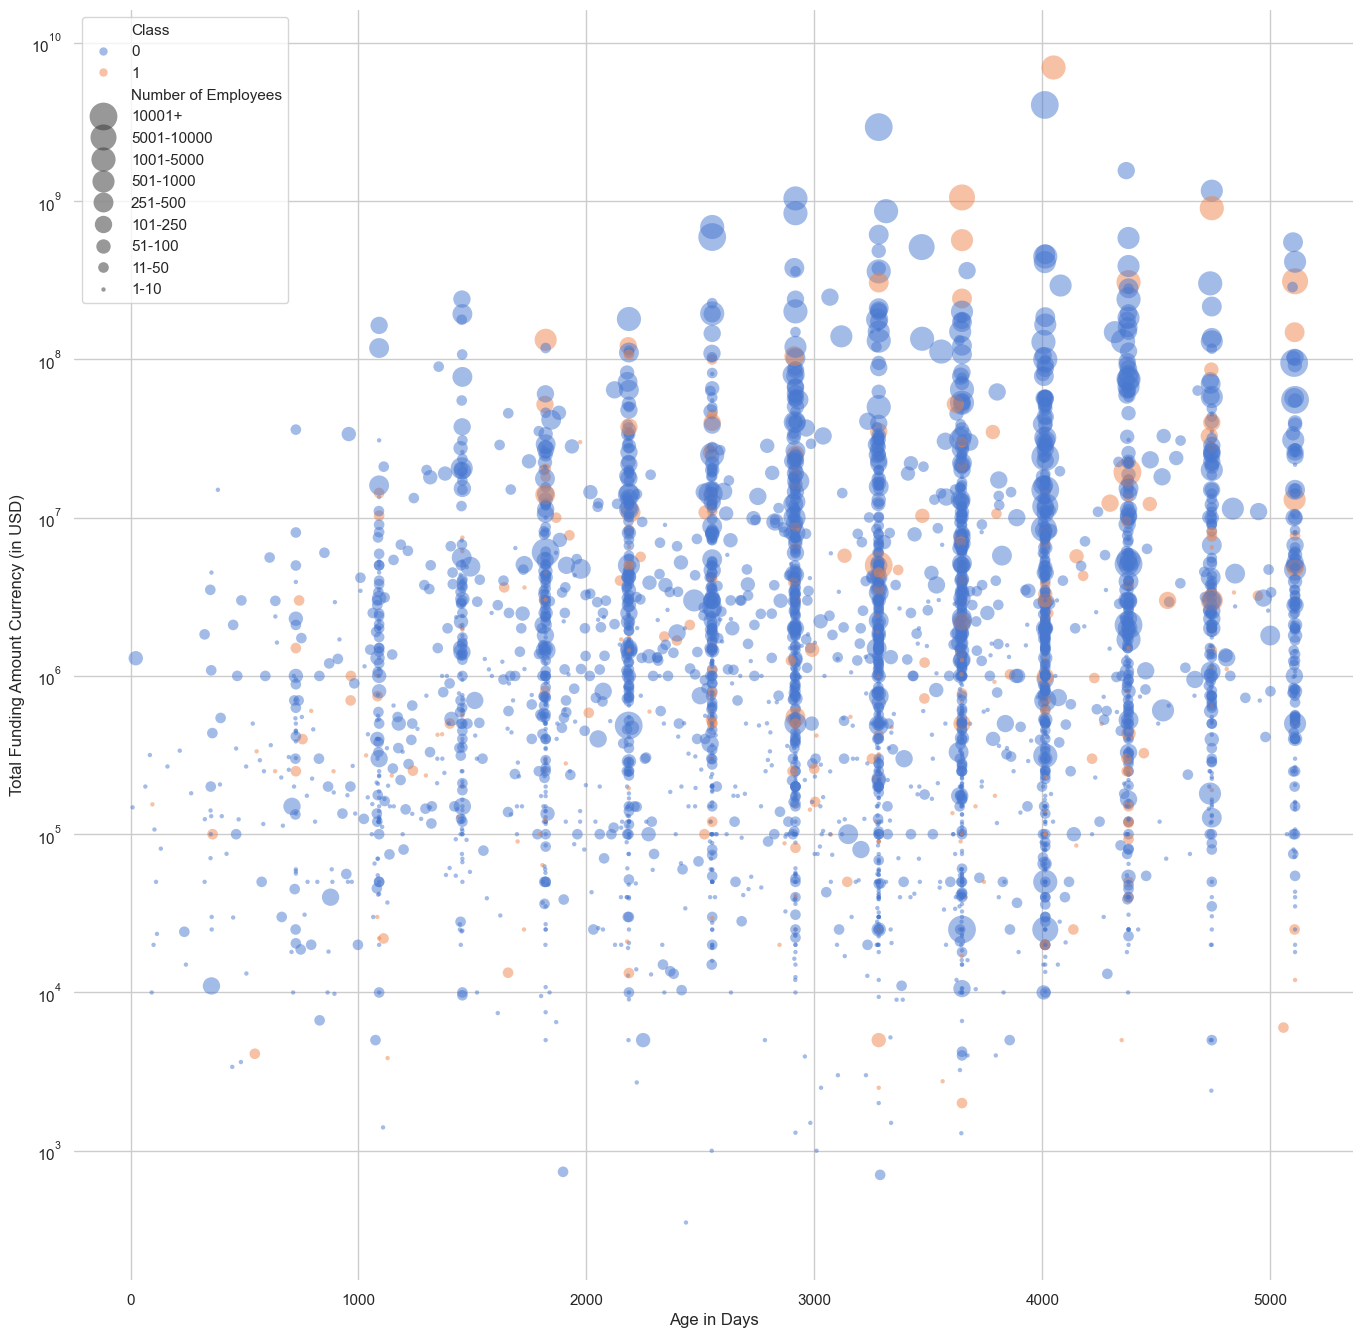

In [131]:
# Draw a scatter plot while assigning point colors and sizes to different variables in the dataset
f, ax = plt.subplots(figsize=(16.5, 16.5))
sns.despine(f, left=True, bottom=True)
#ai_binary = {0: 'non-AI', 1: 'AI'}
size_ranking = ['10001+','5001-10000','1001-5000' ,'501-1000','251-500','101-250','51-100','11-50','1-10']
sns.scatterplot(y="Total Funding Amount Currency (in USD)", x= 'Age in Days',#alt:"Age"
                hue="Class", size="Number of Employees",
                palette= my_colors,
                #hue_order= ai_binary,
                size_order = size_ranking,
                sizes=(10, 400), linewidth=0,
                alpha=.5,
                data=df, ax=ax)
plt.yscale('log')

Notes:
1. Data Quality: a lot of entry dates coincide with the new years
2. AI companies see to be spread out randomly

#cross referncing

ValueError: could not convert string to float: 'NoTosh'

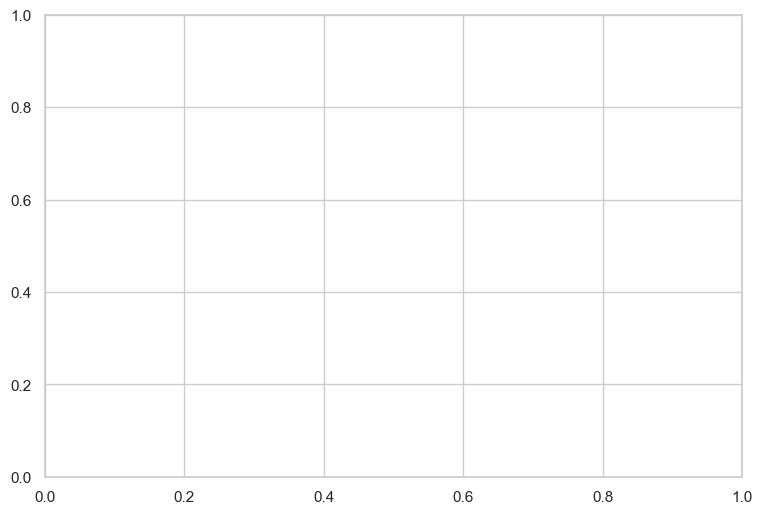

In [132]:
#topics and selfdescribed use of AI

# Draw a heatmap with the relative values of occurance of AI in conjunction with a specific topic in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(x = 'topic', y = 'AI', data = df,  annot=True, fmt="d", linewidths=.5, ax=ax)

#Archive

In [ ]:
# declaring data
data = countries_plt
keys = countries_plt.keys()

# declaring exploding pie
#explode = [0.1, 0, 0, 0, 0, 0]
# define Seaborn color palette to use
palette_color = sns.color_palette('muted')

# plotting data on chart
plt.pie(data,
        labels=keys,
        colors=palette_color,
        autopct='%.0f%%'
        #explode = explode
        )

# displaying chart
plt.show()


In [ ]:
#visualize the results
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    df,
    x="Country", #'Country_top5'
    hue="Number of Employees", #'Employees_>50'
    multiple="stack",
    palette="muted",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
)
#ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_xticks([500, 1000, 2000, 5000, 10000])

In [ ]:
# add 'human readable' labels for each topic to dataset
df['Topic Name'] = [labels_top2vec[int(i)] for i in df['topic']]